In [2]:
import datasets
from datasets import load_dataset
import numpy as np
import os
from PIL import Image, ImageDraw
from transformers import AutoImageProcessor
import albumentations
import numpy as np
import torch
from transformers import AutoModelForObjectDetection
from transformers import TrainingArguments

In [3]:
train_dataset = load_dataset("objdet/train", data_files="_annotations.coco.json")['train']
test_dataset = load_dataset("objdet/test", data_files="_annotations.coco.json")['train']
valid_dataset = load_dataset("objdet/valid", data_files="_annotations.coco.json")['train']

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
test_dataset

Dataset({
    features: ['info', 'licenses', 'categories', 'images', 'annotations'],
    num_rows: 1
})

In [5]:
categories = {}
for i in range(len(train_dataset['categories'][0])):
    categories[train_dataset['categories'][0][i]['id']] = train_dataset['categories'][0][i]['name']
categories

{0: 'football-players-detection',
 1: 'ball',
 2: 'goalkeeper',
 3: 'player',
 4: 'referee'}

В 56 картинке есть ошибка в одном из bbox-ов(Границы выходят за пределы картинки и из-за этого всё падает) так что я её просто скипнул.

In [6]:
def make_dataset(dataset, path):
    images = []
    
    current_box = []
    current_areas = []
    current_category_ids = []
    current_ids = []

    image_id = 0    
    print('size =', len(dataset['annotations'][0]))
    for i in range(len(dataset['annotations'][0])):
        if i % 100 == 0:
            print(i)
        current = dataset['annotations'][0][i]
        if current['image_id'] != image_id:
            if image_id==56:
                image_id += 1
                continue
            image = {}

            current_image = dataset['images'][0][image_id]            

            image['image_id'] = current_image['id']
            image['image'] = Image.open(f'objdet/{path}/{current_image["file_name"]}')
            image['height'] = current_image['height']
            image['width'] = current_image['width']
            
            temp = {}

            temp['id'] = current_ids
            temp['area'] = current_areas
            temp['bbox'] = current_box
            # for i in temp['bbox']:
            #     for j in i:
            #         if j > 1080:
            #             print(i)
            temp['category'] = current_category_ids

            image['objects'] = temp           

            current_box = []
            current_areas = []
            current_category_ids = []
            current_ids = []

            images += [image]

            image_id += 1

        current_box += [current['bbox']]
        current_areas += [current['area']]
        current_category_ids += [current['category_id']]
        current_ids += [current['id']]
    return images

In [7]:
train = datasets.Dataset.from_list(make_dataset(train_dataset, 'train'))
test = datasets.Dataset.from_list(make_dataset(test_dataset, 'test'))
valid = datasets.Dataset.from_list(make_dataset(valid_dataset, 'valid'))

size = 4861
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
size = 310
0
100
200
300
size = 905
0
100
200
300
400
500
600
700
800
900


In [8]:
train

Dataset({
    features: ['image_id', 'image', 'height', 'width', 'objects'],
    num_rows: 202
})

In [9]:
for i in train:
    # print(i)
    # break
    for j in range(len(i['objects']["area"])):
        box = i['objects']["bbox"][j]
        if box[0]+box[2]>1920 or box[1]+box[3]>1080:
            print(box)

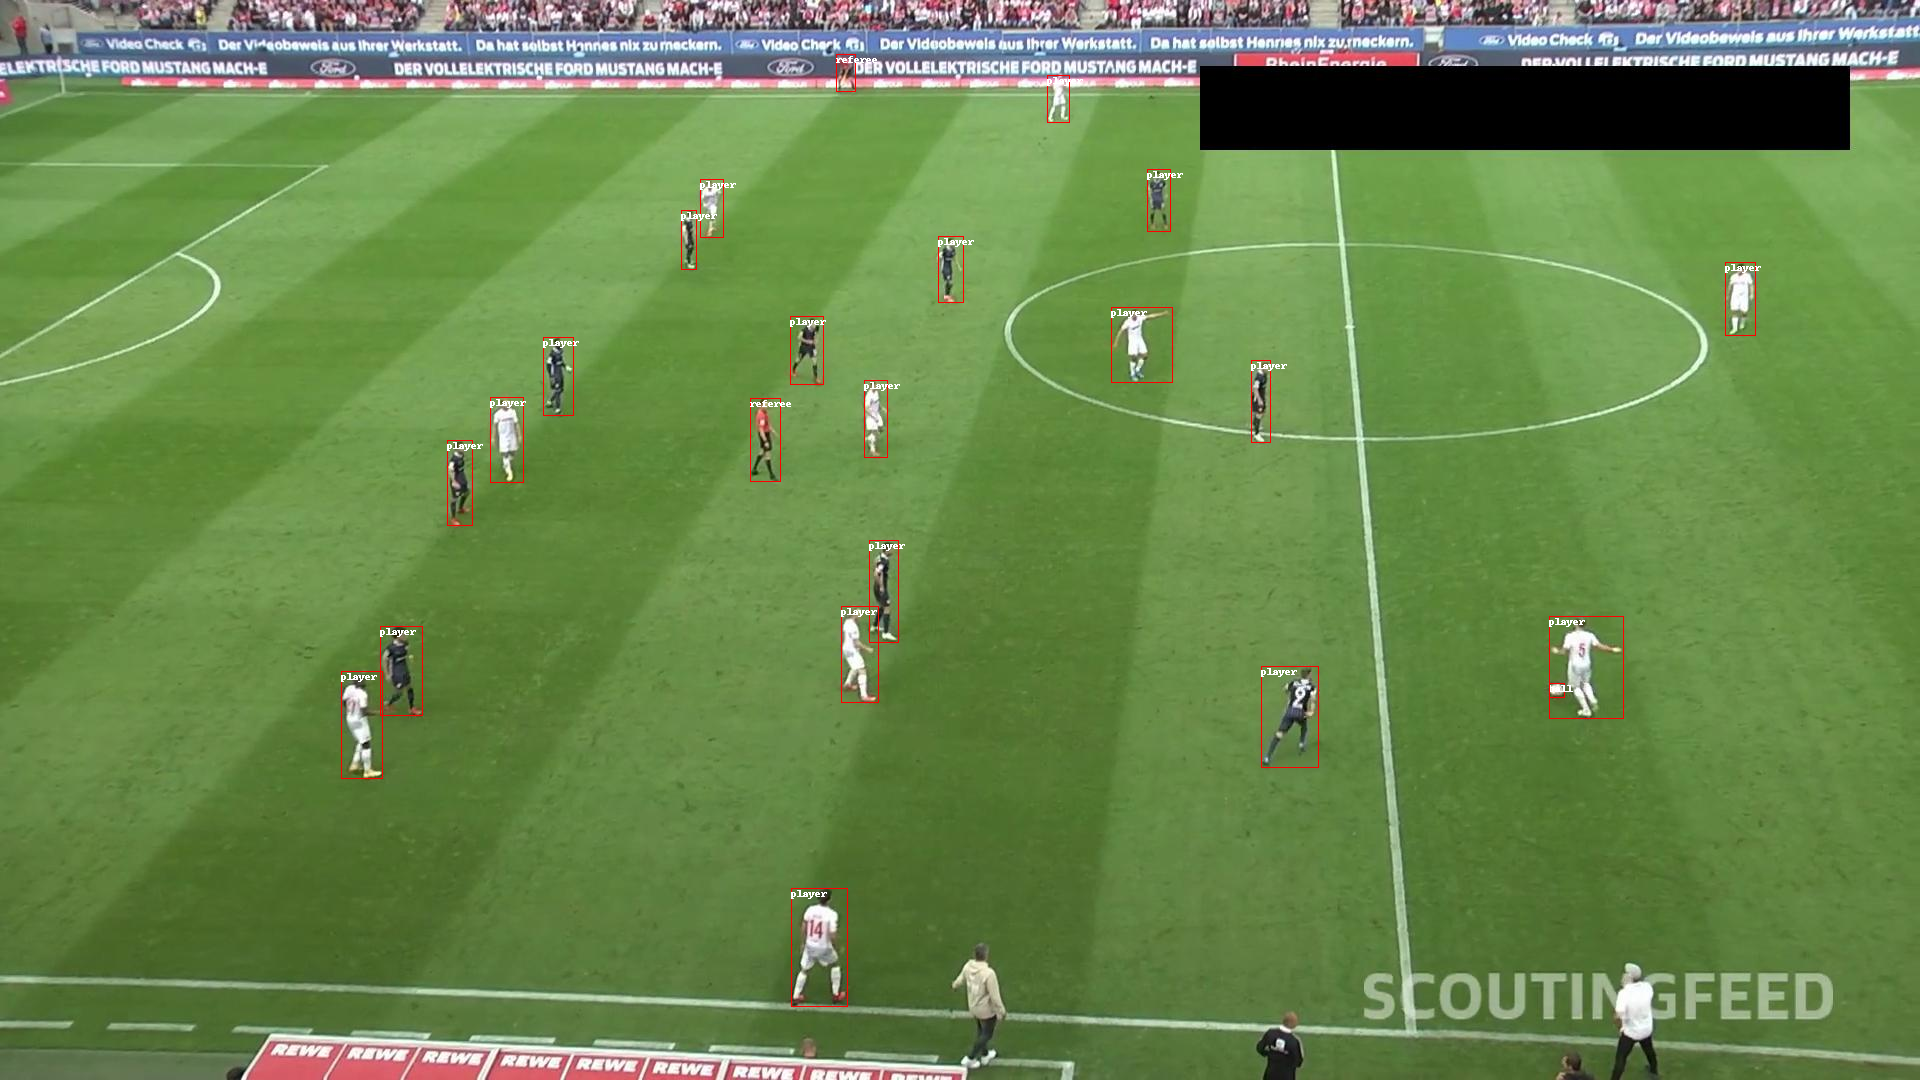

In [10]:
idx = 55
image = train[idx]["image"]
annotations = train[idx]["objects"]
draw = ImageDraw.Draw(image)


id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["area"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    if max(box) > 1.0:
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), categories[class_idx], fill="white")

image

In [11]:
checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [12]:
transform = albumentations.Compose(
    [
        albumentations.Resize(360, 240)
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [13]:
# преобразуем аннотации
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

# для создания одного батча - скомбинируем изображение и аннотацию
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [14]:
train = train.with_transform(transform_aug_ann)

In [15]:
# делаем всё красивее и удобнее
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [16]:
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
# model.to('cuda')

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Простите великодушно, я мог бы запустить его на большее количество эпох, но оно одну то 10 минут обрабатывало, так что да.

In [17]:
training_args = TrainingArguments(
    output_dir='/output',
    per_device_train_batch_size=8,
    num_train_epochs=1,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train,
    tokenizer=image_processor,
)

trainer.train()

  0%|          | 0/26 [00:00<?, ?it/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'train_runtime': 589.4355, 'train_samples_per_second': 0.343, 'train_steps_per_second': 0.044, 'train_loss': 2.8587960463303785, 'epoch': 1.0}


TrainOutput(global_step=26, training_loss=2.8587960463303785, metrics={'train_runtime': 589.4355, 'train_samples_per_second': 0.343, 'train_steps_per_second': 0.044, 'total_flos': 1.4477818749696e+17, 'train_loss': 2.8587960463303785, 'epoch': 1.0})

In [19]:
import json

def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations

def save_cppe5_annotation_file_images(cppe5):
    output_json = {}
    path_output_cppe5 = f"{os.getcwd()}/cppe5/"

    if not os.path.exists(path_output_cppe5):
        os.makedirs(path_output_cppe5)

    path_anno = os.path.join(path_output_cppe5, "cppe5_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in cppe5:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(cppe5["image"], cppe5["image_id"]):
        path_img = os.path.join(path_output_cppe5, f"{img_id}.png")
        im.save(path_img)

    return path_output_cppe5, path_anno

In [20]:
import torchvision


In [21]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, ann_file):
        super().__init__(img_folder, ann_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained("devonho/detr-resnet-50_finetuned_cppe5")

path_output_cppe5, path_anno = save_cppe5_annotation_file_images(test)
test_ds_coco_format = CocoDetection(path_output_cppe5, im_processor, path_anno)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [22]:
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained("devonho/detr-resnet-50_finetuned_cppe5")
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=3, shuffle=False, num_workers=0, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

C:\Users\k_dys\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at devonho/detr-resnet-50_finetuned_cppe5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectD

Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

Detected goalkeeper with confidence 0.513 at location [1299.22, 597.58, 1353.61, 662.45]
Detected goalkeeper with confidence 0.624 at location [783.09, 620.78, 815.52, 682.39]


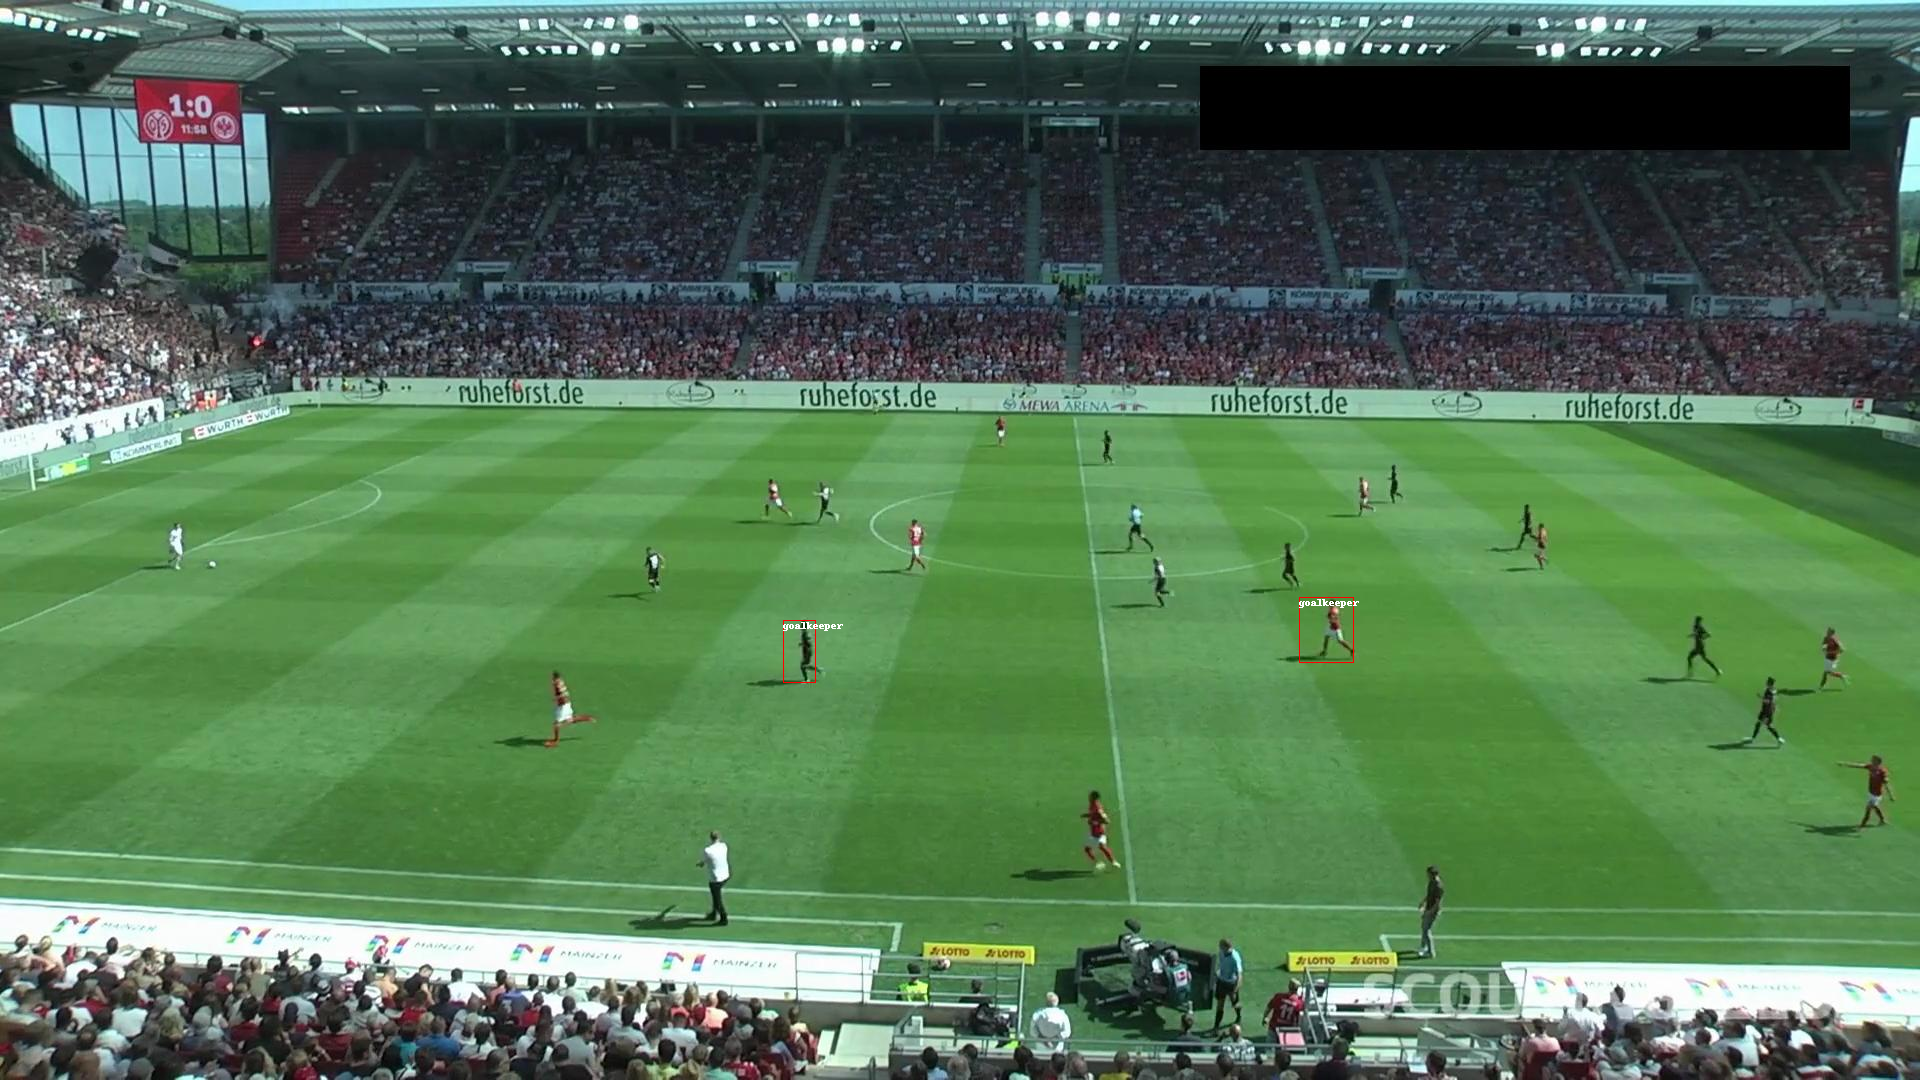

In [25]:
idx = 2
image = Image.open('objdet/test/' + test_dataset['images'][0][idx]["file_name"])
with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {categories[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), categories[label.item()], fill="white")

image